In [1]:
import sys
sys.path = ['',
 '/cm/shared/sw/pkg-old/devel/python2/2.7.13/bin',
 '/mnt/xfs1/flatiron-sw/pkg/devel/python2/2.7.13/lib/python27.zip',
 '/mnt/xfs1/flatiron-sw/pkg/devel/python2/2.7.13/lib/python2.7',
 '/mnt/xfs1/flatiron-sw/pkg/devel/python2/2.7.13/lib/python2.7/plat-linux2',
 '/mnt/xfs1/flatiron-sw/pkg/devel/python2/2.7.13/lib/python2.7/lib-tk',
 '/mnt/xfs1/flatiron-sw/pkg/devel/python2/2.7.13/lib/python2.7/lib-old',
 '/mnt/xfs1/flatiron-sw/pkg/devel/python2/2.7.13/lib/python2.7/lib-dynload',
 '/mnt/xfs1/flatiron-sw/pkg/devel/python2/2.7.13/lib/python2.7/site-packages',
 '/mnt/xfs1/flatiron-sw/pkg/devel/python2/2.7.13/lib/python2.7/site-packages/IPython/extensions',
 '/mnt/home/llevasseur/.ipython']

In [2]:
import tensorflow as tf
import numpy as np
import scipy.io
from skimage.transform import resize


tf.enable_eager_execution()

/mnt/xfs1/flatiron-sw/pkg/devel/python2/2.7.13/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [4]:
execfile("../AE_RIM_definitions.py")
#execfile("genSIEdef_angles.py")

RESTORE = True
train_batch_size = 1
npix_side = 512

with tf.device('/gpu:0'):
    RT = RayTracer()
    #kap_gen = SRC_KAPPA_Generator(train_batch_size=train_batch_size,kap_side_length=20.48,num_src_side=num_features,num_kappa_side=num_features)

    VAE_obj = VAE(n_latent = 64 , npix_side = npix_side)
    checkpoint_path = "../checkpoints/model_VAE_512"
    VAE_obj.load_weights(checkpoint_path)

In [12]:
checkpoint_path = "/mnt/home/llevasseur/Censai/checkpoints/model_Unet_test"
save_checkpoint_path = "../checkpoints/model_RT_VAE"
if (RESTORE==True):
    RT.load_weights(checkpoint_path)

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline  
from IPython import display
import pylab as pl

from mpl_toolkits.axes_grid1 import make_axes_locatable
def colorbar(mappable):
    ax = mappable.axes
    fig = ax.figure
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    return fig.colorbar(mappable, cax=cax)

In [7]:
src_side = 20.48/2
im_side = 20.48

lens_util_obj = lens_util(im_side= im_side, src_side=src_side, numpix_side = npix_side ,kap_side=im_side,  method = "conv2d")

In [8]:
optimizer = tf.train.AdamOptimizer(5.0e-5)

In [9]:
x_alpha = np.zeros((train_batch_size,npix_side, npix_side,1))
y_alpha = np.zeros((train_batch_size,npix_side, npix_side,1))
kappa = np.zeros((train_batch_size,npix_side, npix_side,1))

xim, yim = np.meshgrid( np.linspace(-10.24,10.24,512)*  np.pi / 180 / 3600, np.linspace(-10.24,10.24,512) * np.pi / 180 / 3600)

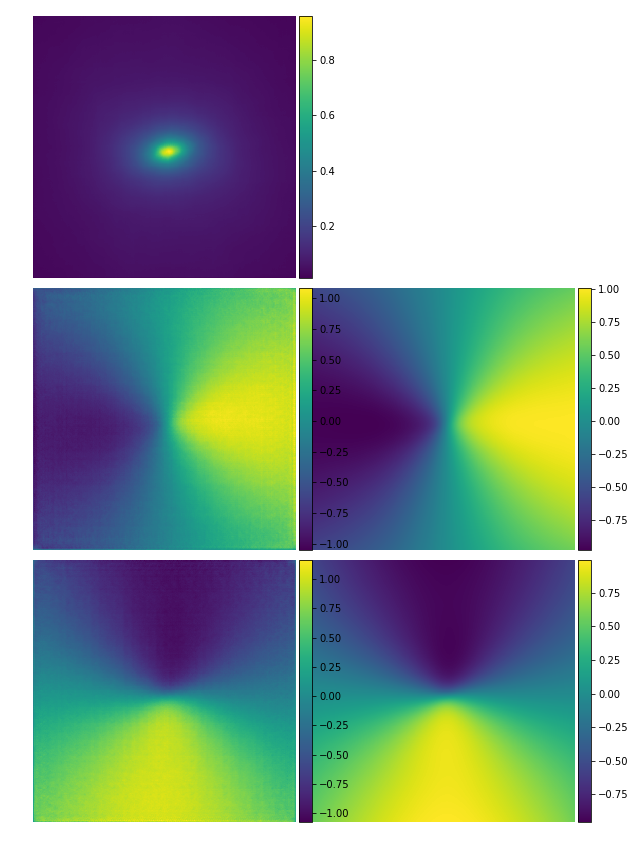

KeyboardInterrupt: 

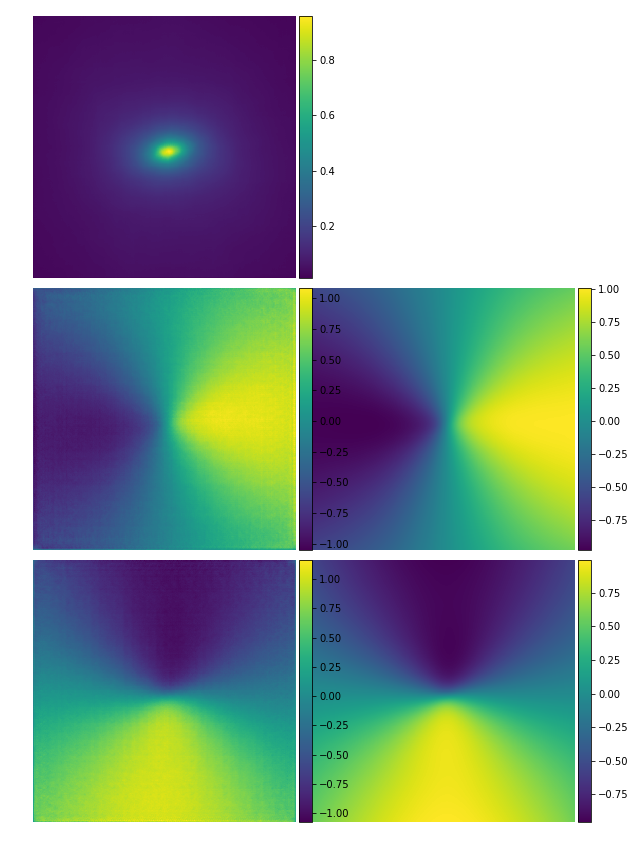

In [10]:
with tf.device('/gpu:0'):
    for epoch in range(1):
        for train_iter in range(40000):
            
            # To train on analytical SIEs
            for i in range(train_batch_size):
                kappa_ims = tf.reshape(VAE_obj.draw_image(train_batch_size), (-1,npix_side,npix_side,1) )
                _ , _ , x_alpha[i,:,:,:] , y_alpha[i,:,:,:] = lens_util_obj.get_deflection_angles(kappa_ims)                
                kappa[i,:,:,0]  = kappa_ims.numpy()[0,:,:,0]
            #x_alpha = x_alpha*180/(np.pi)*3600
            #y_alpha = y_alpha*180/(np.pi)*3600
            x_a_labels = tf.cast( x_alpha, datatype)
            y_a_labels = tf.cast( y_alpha, datatype)
            
            tf_kappa = tf.cast( kappa , datatype)
            

            with tf.GradientTape() as tape:
                tape.watch(RT.variables)
                cost_value , ALFA = RT.cost_function(tf_kappa , x_a_labels , y_a_labels)
            weight_grads = tape.gradient(cost_value, [RT.variables] )

            clipped_grads = [tf.clip_by_value(grads_i,-10,10) for grads_i in weight_grads[0]]
            optimizer.apply_gradients(zip(clipped_grads, RT.variables), global_step=tf.train.get_or_create_global_step())

            print( epoch, train_iter , cost_value.numpy() )
            
            if (((train_iter+1)%1)==0):
                #print( "saving weights." )
                #RT.save_weights(save_checkpoint_path)
                pl.clf()
                fig, ax = pl.subplots(3, 2, figsize = (10, 15))
                pl.subplots_adjust(wspace = 0, hspace = 0)
                p_0 = ax[0, 0].imshow(kappa_ims[0,:,:,0])
                colorbar(p_0)
                p_1 = ax[1, 0].imshow(ALFA[0,:,:,0])
                colorbar(p_1)
                p_2 = ax[1, 1].imshow(x_a_labels[0,:,:,0])
                colorbar(p_2)
                p_3 = ax[2, 0].imshow(ALFA[0,:,:,1])
                colorbar(p_3)
                p_4 = ax[2, 1].imshow(y_a_labels[0,:,:,0])
                colorbar(p_4)
                for j in range(2):
                    for i in range(3):
                        ax[i,j].axis('off')    
                display.clear_output(wait=True)
                display.display(pl.gcf())



            